In [2]:
import matplotlib.pyplot as plt
import numpy as np
import neurobiases

from importlib import reload
from neurobiases import TriangularModel, TCSolver, EMSolver
from neurobiases import utils, plot
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [23]:
reload(plot)

<module 'neurobiases.plot' from '/Users/psachdeva/Documents/projects/neurobiases/neurobiases/plot.py'>

# Experiment 1: Examine whether fits change as a function of identifiability transform

In [3]:
# create triangular model kwargs
tuning_kwargs, coupling_kwargs, noise_kwargs, stim_kwargs = \
    TriangularModel.generate_piecewise_kwargs(M=15, N=20, K=1,
                                              corr_cluster=0.2, corr_back=0.0,
                                              tuning_sparsity=0.6, coupling_sparsity=0.5,
                                              tuning_random_state=233332, coupling_random_state=2)

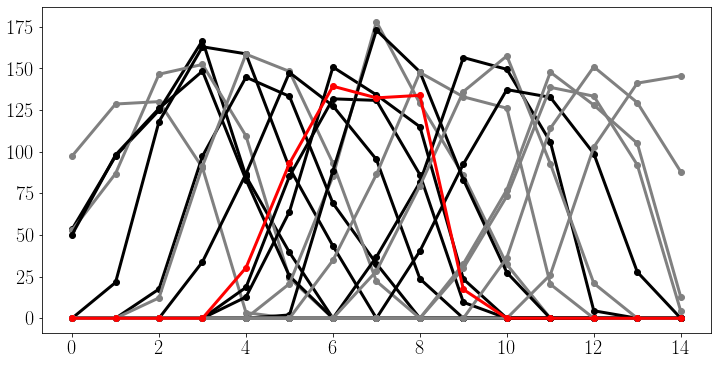

In [4]:
# create triangular model and examine tuning curves
tm = TriangularModel(
    model='linear',
    parameter_design='piecewise',
    tuning_kwargs=tuning_kwargs,
    coupling_kwargs=coupling_kwargs,
    noise_kwargs=noise_kwargs,
    stim_kwargs=stim_kwargs
)
tm.plot_tuning_curves(neuron='all')
plt.show()

In [5]:
n_deltas = 1000
n_reps = 10
deltas = np.linspace(-10, 10, n_deltas)
a_start = np.copy(tm.a.ravel())
b_start = np.copy(tm.b.ravel())
a_hats = np.zeros((n_deltas, n_reps, tm.N))
b_hats = np.zeros((n_deltas, n_reps, tm.M))

In [6]:
# calculate tuning/coupling parameters for each identifiability parameters
for idx, delta in enumerate(deltas):
    tm.identifiability_transform(delta=delta)
    for rep in range(n_reps):
        X, Y, y = tm.generate_samples(n_samples=1000)
        solver = TCSolver(X, Y, y, a_mask=a_start != 0, b_mask=b_start != 0)
        a_hats[idx, rep], b_hats[idx, rep] = solver.fit_ols()
    tm.identifiability_transform(delta=-delta)

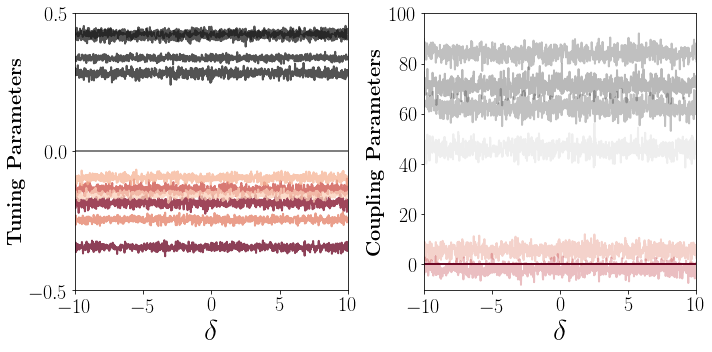

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# iterate over coupling parameters
for idx in range(tm.N):
    # plot trajectory of parameter over delta
    axes[0].plot(deltas, np.mean(a_hats[:, :, idx], axis=1),
                 color=plot.get_cmap_color('RdGy', a_start[idx], a_start.min(), a_start.max()),
                 alpha=0.75,
                 linewidth=2)

# iterate over coupling parameters
for idx in range(tm.M):
    # plot trajectory of parameter over delta
    axes[1].plot(deltas, np.mean(b_hats[:, :, idx], axis=1),
                 color=plot.get_cmap_color('RdGy', b_start[idx], b_start.min(), b_start.max()),
                 alpha=0.30,
                 linewidth=2)
    
axes[0].set_ylim([-0.5, 0.5])
axes[0].set_yticks([-0.5, 0, 0.5])
axes[1].set_ylim([-10, 100])

axes[0].set_ylabel(r'\textbf{Tuning Parameters}', fontsize=20)
axes[1].set_ylabel(r'\textbf{Coupling Parameters}', fontsize=20)

for ax in axes:
    ax.set_xlim([-10, 10])
    ax.set_xlabel(r'$\delta$', fontsize=30)

plt.tight_layout()
plt.savefig('fits_vs_identifiability_same_selection.pdf', bbox_inches='tight')

# Experiment 2: Examine how a different selection profile impacts the fit

In [17]:
# create triangular model kwargs
tuning_kwargs, coupling_kwargs, noise_kwargs, stim_kwargs = \
    TriangularModel.generate_piecewise_kwargs(M=15, N=20, K=1,
                                              corr_cluster=0.2, corr_back=0.0,
                                              tuning_sparsity=0.6, coupling_sparsity=0.5,
                                              tuning_random_state=233332, coupling_random_state=2)

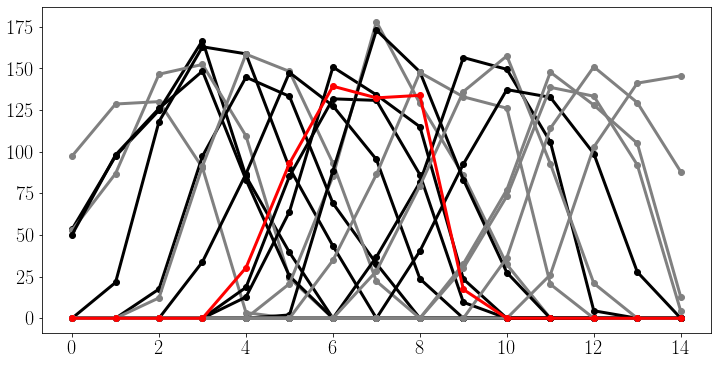

In [18]:
# create triangular model and examine tuning curves
tm = TriangularModel(
    model='linear',
    parameter_design='piecewise',
    tuning_kwargs=tuning_kwargs,
    coupling_kwargs=coupling_kwargs,
    noise_kwargs=noise_kwargs,
    stim_kwargs=stim_kwargs
)
tm.plot_tuning_curves(neuron='all')
plt.show()

In [19]:
n_deltas = 1000
n_reps = 10
deltas = np.linspace(-10, 10, n_deltas)
a_start = np.copy(tm.a.ravel())
b_start = np.copy(tm.b.ravel())
a_hats = np.zeros((n_deltas, n_reps, tm.N))
b_hats = np.zeros((n_deltas, n_reps, tm.M))

In [20]:
# calculate tuning/coupling parameters for each identifiability parameters
for idx, delta in enumerate(deltas):
    tm.identifiability_transform(delta=delta)
    for rep in range(n_reps):
        X, Y, y = tm.generate_samples(n_samples=1000)
        solver = TCSolver(X, Y, y, a_mask=None, b_mask=None)
        a_hats[idx, rep], b_hats[idx, rep] = solver.fit_ols()
    tm.identifiability_transform(delta=-delta)

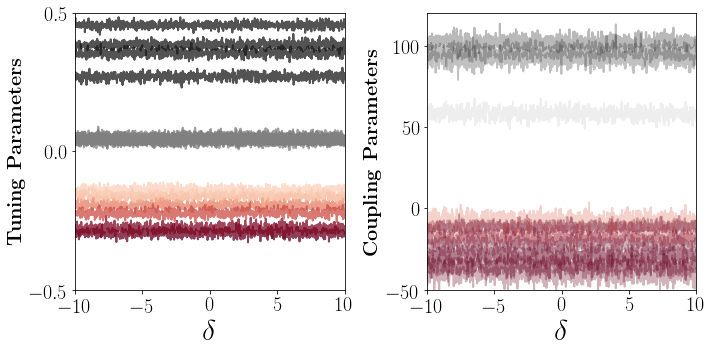

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# iterate over coupling parameters
for idx in range(tm.N):
    # plot trajectory of parameter over delta
    axes[0].plot(deltas, np.mean(a_hats[:, :, idx], axis=1),
                 color=plot.get_cmap_color('RdGy', a_start[idx], a_start.min(), a_start.max()),
                 alpha=0.75,
                 linewidth=2)

# iterate over coupling parameters
for idx in range(tm.M):
    # plot trajectory of parameter over delta
    axes[1].plot(deltas, np.mean(b_hats[:, :, idx], axis=1),
                 color=plot.get_cmap_color('RdGy', b_start[idx], b_start.min(), b_start.max()),
                 alpha=0.30,
                 linewidth=2)
    
axes[0].set_ylim([-0.5, 0.5])
axes[0].set_yticks([-0.5, 0, 0.5])
axes[1].set_ylim([-50, 120])

axes[0].set_ylabel(r'\textbf{Tuning Parameters}', fontsize=20)
axes[1].set_ylabel(r'\textbf{Coupling Parameters}', fontsize=20)

for ax in axes:
    ax.set_xlim([-10, 10])
    ax.set_xlabel(r'$\delta$', fontsize=30)

plt.tight_layout()

In [21]:
solver = TCSolver(X, Y, y, a_mask=a_start != 0, b_mask=b_start != 0)
a_hat, b_hat = solver.fit_ols()

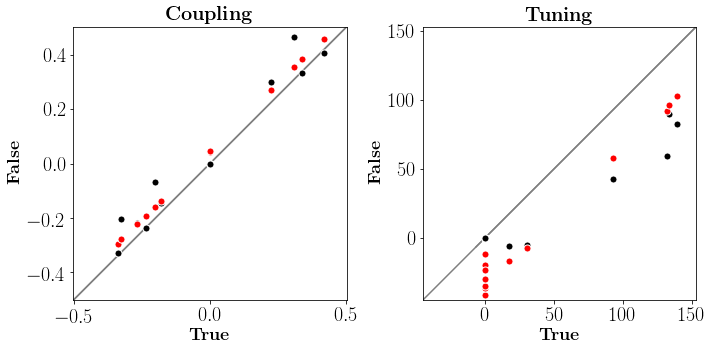

In [33]:
fig, axes = plot.plot_tc_fits(a_hat, a_start, b_hat, b_start, fax=None, color='black')
plot.plot_tc_fits(np.mean(a_hats, axis=(0, 1)), a_start,
                  np.mean(b_hats, axis=(0, 1)), b_start,
                  color='red',
                  fax=(fig, axes))

for ax in axes:
    ax.set_xlabel(r'\textbf{True}', fontsize=18)
    ax.set_ylabel(r'\textbf{False}', fontsize=18)

axes[0].set_title(r'\textbf{Coupling}', fontsize=20)
axes[1].set_title(r'\textbf{Tuning}', fontsize=20)
plt.tight_layout()
plt.show()